# Duan 2024 Paper Analysis
This looks at how near-surface MSE can exceed the limit posed by WTG-CQE, due to entrainment of dry air in the lower free troposphere.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p
from isca_tools.utils import area_weighting, annual_mean
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import interpolate
import matplotlib.animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

2024-09-11 12:11:20,981 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [336]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 'precipitation', 'omega', 'ucomp', 'vcomp', 'convflag', 'klzbs']  
# Load dataset
tau_lw_ref = 1
# exp_dir = 'tau_sweep/aquaplanet/depth=1/'
exp_dir = 'tau_sweep/land/meridional_band/depth=1/bucket_evap/'
exp_name = f"k={str(tau_lw_ref).replace('.','_')}"

# exp_dir = 'rossbypalooza/variable_evap_flux/evap=0/'
# exp_name=''

use_time_start = 360*2
ds_use = isca_tools.load_dataset(exp_dir + exp_name)
try:
    ds_use = ds_use[var_keep]
except KeyError:
    remove_keys = []
    for key in var_keep:
        if key not in ds_use:
            print(f'Removing {key} from var_keep')
            remove_keys += [key]
    for key in remove_keys:
        var_keep.remove(key)
    ds_use = ds_use[var_keep]
ds_base = ds_use.sel(time=slice(use_time_start, np.inf))      # only keep after spin up
namelist = isca_tools.load_namelist(exp_dir + exp_name)  # Need this for albedo_value
albedo = namelist['mixed_layer_nml']['albedo_value']
tau_sw = namelist['two_stream_gray_rad_nml']['atm_abs']
tau_lw = namelist['two_stream_gray_rad_nml']['odp']

## Get datasets

In [337]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [388]:
# Load in dataset with surface and free troposphere across all latitudes, for given season
# use_time_start = 0      # because little data

# Chose whether to only consider summer days for mean or all days
summer_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH 
summer_months = {'nh': [5, 6, 7, 8, 9, 10], 'sh': [11, 12, 1, 2, 3, 4]}   # JJA for NH and DJF for SH 
use_summer = True      # if true, will set ds will only contain summer months. Do this outside tropics

region = 'tropics'
lat_min = -20
lat_max = 20
lat_use_ind = np.where((ds_base.lat <= lat_max) & (ds_base.lat >= lat_min))[0]      # just NH to save memory


p_surf_approx = 1000
p_dry_approx = 850
p_ft_approx = 500

if use_summer:
    ds_nh_summer = isca_tools.utils.annual_time_slice(ds_base, summer_months['nh']).sel(lat=slice(0, 90))  
    ds_sh_summer = isca_tools.utils.annual_time_slice(ds_base, summer_months['sh']).sel(lat=slice(-90, 0)) 
    # Combine hemispheres and average over longitude, time and latitude.
    ds = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
else:
    ds = ds_base
ds = ds.sel(pfull=[p_surf_approx, p_dry_approx, p_ft_approx], method='nearest')
ds = ds.isel(lat=lat_use_ind).load()

n_lat = ds.lat.shape[0]
n_pressure = ds.pfull.shape[0]
lat_weights = np.cos(np.deg2rad(ds.lat))     # latitude area weighting is just the cosine
ind_surf = int(np.abs(ds.pfull-p_surf_approx).argmin())
ind_dry = int(np.abs(ds.pfull-p_dry_approx).argmin())
ind_ft = int(np.abs(ds.pfull-p_ft_approx).argmin())
p_surf = float(ds.pfull[ind_surf]) * 100
p_dry = float(ds.pfull[ind_dry]) * 100
p_ft = float(ds.pfull[ind_ft]) * 100

# Compute zonal mean MSE across land and ocean together
mse_ft_zm = moist_static_energy(ds.isel(pfull=ind_ft).temp, sphum_sat(ds.isel(pfull=ind_ft).temp, p_ft), 
                                ds.isel(pfull=ind_ft).height).mean(dim='lon')

# if land, have separate dataset for land and ocean
job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, exp_name, 'land.nc')
is_land_data = os.path.exists(land_file_name)
if is_land_data:
    n_exp = 2
    if 'variable_evap_flux' not in exp_dir:
        lon_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]       # get the longitude coordinates of land
        lon_ocean = isca_tools.utils.land.get_ocean_coords(land_file=land_file_name)[1]       # get the longitude coordinates of land
        ds = [ds.isel(lon=np.where(np.isin(ds.lon, np.unique(lon_ocean)))[0]), 
              ds.isel(lon=np.where(np.isin(ds.lon, np.unique(lon_land)))[0])]
        exp_labels = ['Ocean', 'Land']
    else:
        ds = [ds.sel(lon=slice(91, 359)), ds.sel(lon=slice(0, 90))]
        exp_labels = ['Evap=1', 'Evap=0']
else:
    ds = [ds]
    n_exp = 1
    exp_labels = [f'$\kappa = {tau_lw}$']

In [389]:
mse_ft_anom = [moist_static_energy(ds[i].isel(pfull=ind_ft).temp, sphum_sat(ds[i].isel(pfull=ind_ft).temp, p_ft), 
                                   ds[i].isel(pfull=ind_ft).height) - mse_ft_zm for i in range(n_exp)]
mse_surf = [moist_static_energy(ds[i].isel(pfull=ind_surf).temp, ds[i].isel(pfull=ind_surf).sphum, ds[i].isel(pfull=ind_surf).height) 
            for i in range(n_exp)]
subsat = [L_v * (ds[i].isel(pfull=ind_dry).sphum - sphum_sat(ds[i].isel(pfull=ind_dry).temp, p_dry)) / 1000 for i in range(n_exp)]

## Lower free troposphere dryness vs Boundary layer instability

The quantity $MSE_{ZM}$ is the zonal mean, taken across all ocean and land longitude coordinates. 
$Subsat = L_v(q - q^*)$

### Scatter
The diagonal purple line gives the upper limit from Duan 2024, the vertical line gives the WTG-CQE upper limit.

Text(0, 0.5, "Subsat$_{860}$ - (MSE$^*_{486}$)' [kJ/kg]")

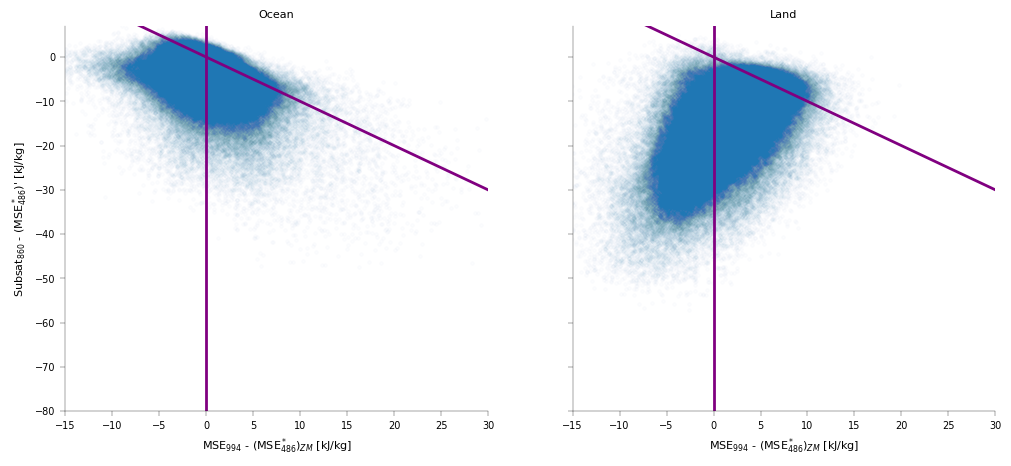

In [390]:
fig, ax = plt.subplots(1, n_exp, figsize=(n_exp*6, 5), sharex=True, sharey=True)
if n_exp == 1:
    ax = [ax]
for i in range(n_exp):
    ax[i].scatter(mse_surf[i] - mse_ft_zm, subsat[i]-mse_ft_anom[i], alpha=0.01)
    ax[i].plot(np.arange(-40, 80), -np.arange(-40, 80), color='purple', lw=2)
    ax[i].axvline(0, color='purple', lw=2)
    ax[i].set_xlabel(f"MSE$_{'{'+str(int(p_surf/100))+'}'}$ - (MSE$^*_{'{'+str(int(p_ft/100))+'}'}$)$_{'{ZM}'}$ [kJ/kg]")
    ax[i].set_title(exp_labels[i])
ax[0].set_ylim(-80, 7)
ax[0].set_xlim(-15, 30)
ax[0].set_ylabel(f"Subsat$_{'{'+str(int(p_dry/100))+'}'}$ - (MSE$^*_{'{'+str(int(p_ft/100))+'}'}$)' [kJ/kg]")
# ax.scatter(mse_surf - mse_ft_zm - mse_ft_anom, subsat-mse_ft_anom, alpha=0.01)
# ax[1].scatter(ds[1].temp[-1]-ds[0].temp[-1], ds[1].sphum[-1]-ds[0].sphum[-1], alpha=0.01, 
#               c=ds[0].temp[-1], vmin=280, vmax=300)
# im = ax[1].scatter(0, 0, c=5, s=0, vmin=280, vmax=300)       # add a marker you can't see, for the colorbar
# plt.colorbar(im, label=f'$\kappa={tau_lw[0]}$ temperature [K]')
# 
# fig.supxlabel('Near-surface Temperature [K]', fontsize=8)
# ax[0].set_ylabel('Near-surface Specific Humidity [kg/kg]')
# ax[0].set_title(f'Reference: $\kappa={tau_lw[0]}$')
# ax[1].set_title(f'Difference: $(\kappa={tau_lw[1]}) - (\kappa={tau_lw[0]})$')
# plt.tight_layout()

### 2D Probability Distribution
Below I plot the probability distribution of dry (orange) and rainy (green) days.

In [391]:
def get_hist_2d(x, y, n_bins=10, bin_lower=None, bin_upper=None):
    # Returns hist counts and center of each bin
    x = x.to_numpy().flatten()
    y = y.to_numpy().flatten()
    use = np.logical_and(np.isfinite(x), np.isfinite(y))
    if bin_lower is None:
        bin_lower = [x[use].min(), y[use].min()]
    if bin_upper is None:
        bin_upper = [x[use].max(), y[use].max()]
    hist_counts, hist_bins_x, hist_bins_y = np.histogram2d(x[use], y[use], bins=n_bins, 
                                                           range=[[bin_lower[i], bin_upper[i]] for i in range(2)])
    # Transpose is crucial for plotting
    return hist_counts.T, np.convolve(hist_bins_x, np.ones(2)/2, mode='valid'), np.convolve(hist_bins_y, np.ones(2)/2, mode='valid')

Text(0, 0.5, "Subsat$_{860}$ - (MSE$^*_{486}$)' [kJ/kg]")

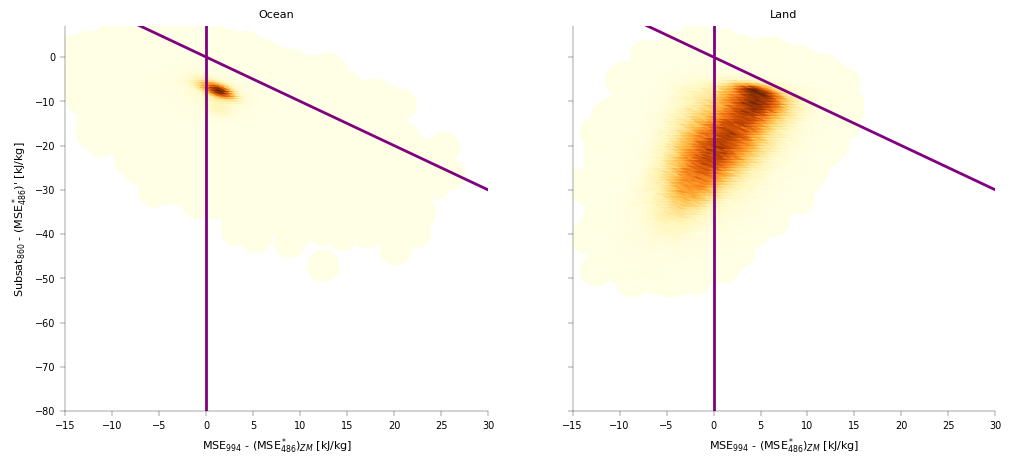

In [392]:
precip_thresh = 1/10000          # precip threshold is 0.1g/m^2/s
precip_thresh = 1000      # so plots all days
precip_cmap = ['YlOrBr', 'Greens']
precip_count_thresh = [0.3, 0.8]
n_bins = 100

fig, ax = plt.subplots(1, n_exp, figsize=(n_exp*6, 5), sharex=True, sharey=True)
if n_exp == 1:
    ax = [ax]
for j in range(n_exp):
    precip_use = [ds[j].precipitation<precip_thresh, ds[j].precipitation>=precip_thresh]
    for i in range(len(precip_use)):
        if precip_use[i].sum()==0:
            continue
        count, var_x, var_y = get_hist_2d((mse_surf[j] - mse_ft_zm).where(precip_use[i]), (subsat[j]-mse_ft_anom[j]).where(precip_use[i]), 
                                          n_bins=n_bins)
        var_x, var_y = np.meshgrid(var_x, var_y)
        count_sum = np.sum(count)
        count[count<np.quantile(count[count>0], precip_count_thresh[i])] = np.nan
        ax[j].scatter(var_x.flatten(), var_y.flatten(), c=count.flatten()/count_sum, cmap=precip_cmap[i], alpha=0.5 if i==1 else 1, s=50000/n_bins)
    ax[j].plot(np.arange(-40, 40), -np.arange(-40, 40), color='purple', lw=2)
    ax[j].axvline(0, color='purple', lw=2)
    ax[j].set_xlabel(f"MSE$_{'{'+str(int(p_surf/100))+'}'}$ - (MSE$^*_{'{'+str(int(p_ft/100))+'}'}$)$_{'{ZM}'}$ [kJ/kg]")
    ax[j].set_title(exp_labels[j])
ax[0].set_ylim(-80, 7)
ax[0].set_xlim(-15, 30)
ax[0].set_ylabel(f"Subsat$_{'{'+str(int(p_dry/100))+'}'}$ - (MSE$^*_{'{'+str(int(p_ft/100))+'}'}$)' [kJ/kg]")

In [393]:
# area_weighting(subsat[0]).mean(dim='lat').quantile(np.arange(1, 100)/100).plot(label=exp_labels[0])
# area_weighting(subsat[1]).mean(dim='lat').quantile(np.arange(1, 100)/100).plot(label=exp_labels[1])
# plt.ylabel('Subsat, $L_v (q-q^*)$ [kJ/kg]')
# plt.legend()
# plt.xlim(0, 1)

### Does deviation from convective equilibrium increase with lower free troposphere dryness?
Below, I show that as the lower free troposphere becomes more dry, there is no clear trend for near-surface MSE to exceed the free troposphere saturated value.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'MSE$_{994}$ - MSE$^*_{486}$ [kJ/kg]')

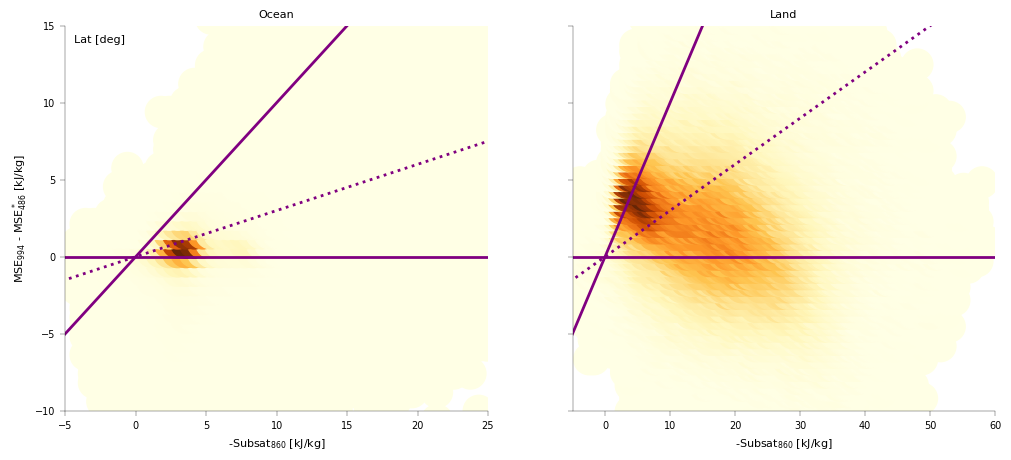

In [394]:
color_seq_lat = plt.cm.jet(np.linspace(0,1,int(n_lat/2)))
# color_seq_lat = plt.cm.jet(np.linspace(0,1,n_quant_all))
fig, ax = plt.subplots(1, n_exp, figsize=(n_exp*6, 5), sharex=False, sharey=True)
if n_exp == 1:
    ax = [ax]
for j in range(n_exp):
    precip_use = [ds[j].precipitation<precip_thresh, ds[j].precipitation>=precip_thresh]
    for i in range(len(precip_use)):
        if precip_use[i].sum()==0:
            continue
        count, var_x, var_y = get_hist_2d((-subsat[j]).where(precip_use[i]), (mse_surf[j] - (mse_ft_zm+mse_ft_anom[j])).where(precip_use[i]), 
                                          n_bins=n_bins)
        var_x, var_y = np.meshgrid(var_x, var_y)
        count_sum = np.sum(count)
        count[count<np.quantile(count[count>0], precip_count_thresh[i])] = np.nan
        ax[j].scatter(var_x.flatten(), var_y.flatten(), c=count.flatten()/count_sum, cmap=precip_cmap[i], alpha=0.5 if i==1 else 1, s=50000/n_bins)
    ax[j].axhline(0, color='purple', lw=2)
    ax[j].set_xlabel(f"-Subsat$_{'{'+str(int(p_dry/100))+'}'}$ [kJ/kg]")
    ax[j].set_title(exp_labels[j])
    ax[j].plot(np.arange(-80, 80), np.arange(-80, 80), color='purple', lw=2)
    ax[j].plot(np.arange(-80, 80), 0.3*np.arange(-80, 80), color='purple', lw=2, linestyle=':')
    # for k in range(int(n_lat/2)):
    #     ax[j].scatter(subsat_quant3[j, k, -25:], epsilon_quant3[j, k, -25:], color=color_seq_lat[k], label=int(np.abs(ds[0].lat[k])))
    #     ax[j].scatter(subsat_quant3[j, -1-k, -25:], epsilon_quant3[j, -1-k, -25:], color=color_seq_lat[k])
    # for k in range(n_quant_all):
    #     ax[j].scatter(subsat_quant3[j, 0, k], epsilon_quant3[j, 0, k], color=color_seq_lat[k])
ax[1].set_ylim(-10, 15)
ax[1].set_xlim(-5, 60)
ax[0].set_xlim(-5, 25)
ax[0].legend(title='Lat [deg]')
# ax.plot(np.arange(-20, 40), -np.arange(-20, 40), color='purple', lw=2)
ax[0].set_ylabel(f"MSE$_{'{'+str(int(p_surf/100))+'}'}$ - MSE$^*_{'{'+str(int(p_ft/100))+'}'}$ [kJ/kg]")

## As function of Near-surface Temperature Quantile

In [395]:
pressure_from_level_func = scipy.interpolate.interp1d(np.arange(len(ds_base.pfull)), ds_base.pfull)
def lzb(k, interp_func=pressure_from_level_func):
    # Offset by -1 because fortran starts with 1, but python starts with 0
    # ds.t_ref will match exactly ds.temp if -2 used as offset, but this is not the LNB.
    if np.size(k) == 1:
        return float(interp_func(k-1))
    else:
        return interp_func(k-1)

In [396]:
quantiles_all = np.arange(1, 100)   # avoid 0 quantile as it gives weird results
n_quant_all = len(quantiles_all)    

lzb_thresh = 12     # Need klzb to be lower than this so LZB is less than 560hPa (14) or 413hPa (12)
convflag_thresh = 1      # Need more than this to be considered shallow convection
epsilon_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
subsat_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
r_quant3 = np.zeros((n_exp, n_pressure, n_lat, n_quant_all))
pressure_lcl_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
convflag_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
fract_convecting_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
klzbs_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
with tqdm(total=n_exp*n_quant_all*n_lat, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1)).load()
        epsilon_use = moist_static_energy(ds_use.temp[ind_surf], ds_use.sphum[ind_surf], ds_use.height[ind_surf]) - \
            moist_static_energy(ds_use.temp[ind_ft], sphum_sat(ds_use.temp[ind_ft], p_ft), ds_use.height[ind_ft])
        subsat_use = L_v * (sphum_sat(ds_use.temp[ind_dry], p_dry) - ds_use.sphum[ind_dry]) / 1000
        r_use = np.asarray([ds_use.sphum[k] / sphum_sat(ds_use.temp[k], ds_use.pfull[k]*100).to_numpy() for k in range(n_pressure)])
        keep_deep_use = np.logical_and(ds_use.klzbs<lzb_thresh, ds_use.convflag > convflag_thresh)
        for j in range(n_lat):
            for q, quant in enumerate(quantiles_all):
                use_ind = get_quant_ind(ds_use.temp[ind_surf, j], quant, 0.5, 0.5)
                epsilon_quant3[i, j, q] = epsilon_use[j, use_ind].mean()
                subsat_quant3[i, j, q] = subsat_use[j, use_ind].mean()
                r_quant3[i, :, j, q] = np.nanmean(r_use[:, j, use_ind], axis=-1)
                convflag_quant3[i, j, q] = ds_use.convflag[j, use_ind].mean()
                klzbs_quant3[i, j, q] = ds_use.klzbs[j, use_ind].mean()
                fract_convecting_quant3[i, j, q] = keep_deep_use[j, use_ind].sum()/len(use_ind)
                
                temp_use = ds_use.temp[ind_surf, j, use_ind].mean()
                sphum_use = ds_use.sphum[ind_surf, j, use_ind].mean()
                pressure_lcl_quant3[i, j, q] = dry_profile_pressure(temp_use, p_surf, lcl_temp(temp_use, p_surf, sphum_use))
                pbar.update(1)

100%|██████████| 2772/2772 [01:06<00:00, 41.84it/s]


In [397]:
ds_profile = ds_base
if use_summer:
    ds_nh_summer = isca_tools.utils.annual_time_slice(ds_base, summer_months['nh']).sel(lat=slice(0, 90))  
    ds_sh_summer = isca_tools.utils.annual_time_slice(ds_base, summer_months['sh']).sel(lat=slice(-90, 0)) 
    # Combine hemispheres and average over longitude, time and latitude.
    ds_profile = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
else:
    ds_profile = ds_base
ds_profile = ds_profile.isel(lat=lat_use_ind)[['temp', 'sphum']].load()

if is_land_data:
    n_exp = 2
    if 'variable_evap_flux' not in exp_dir:
        lon_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]       # get the longitude coordinates of land
        lon_ocean = isca_tools.utils.land.get_ocean_coords(land_file=land_file_name)[1]       # get the longitude coordinates of land
        ds_profile = [ds_profile.isel(lon=np.where(np.isin(ds_profile.lon, np.unique(lon_ocean)))[0]), 
              ds_profile.isel(lon=np.where(np.isin(ds_profile.lon, np.unique(lon_land)))[0])]
        exp_labels = ['Ocean', 'Land']
    else:
        ds_profile = [ds_profile.sel(lon=slice(91, 359)), ds_profile.sel(lon=slice(0, 90))]
        exp_labels = ['Evap=1', 'Evap=0']
else:
    ds_profile = [ds_profile]
    n_exp = 1
    exp_labels = [f'$\kappa = {tau_lw}$']

In [398]:
subsat_profile_quant3 = np.zeros((n_exp, ds_profile[0].pfull.size, n_lat, n_quant_all))
r_profile_quant3 = np.zeros((n_exp, ds_profile[0].pfull.size, n_lat, n_quant_all))
with tqdm(total=n_exp*n_quant_all*n_lat, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds_profile[i].stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1)).load()
        subsat_use = np.asarray([L_v * (sphum_sat(ds_use.temp[k], ds_use.pfull[k]*100) - 
                                        ds_use.sphum[k]).to_numpy() / 1000 for k in range(ds_use.pfull.size)])
        r_use = np.asarray([(ds_use.sphum[k] / sphum_sat(ds_use.temp[k], ds_use.pfull[k]*100)).to_numpy() for k in range(ds_use.pfull.size)])
        for j in range(n_lat):
            for q, quant in enumerate(quantiles_all):
                use_ind = get_quant_ind(ds_use.temp[-1, j], quant, 0.5, 0.5)
                subsat_profile_quant3[i, :, j, q] = np.nanmean(subsat_use[:, j, use_ind], axis=-1)
                r_profile_quant3[i, :, j, q] = np.nanmean(r_use[:, j, use_ind], axis=-1)
                pbar.update(1)

100%|██████████| 2772/2772 [00:21<00:00, 127.19it/s]


(1000.0, 300.0)

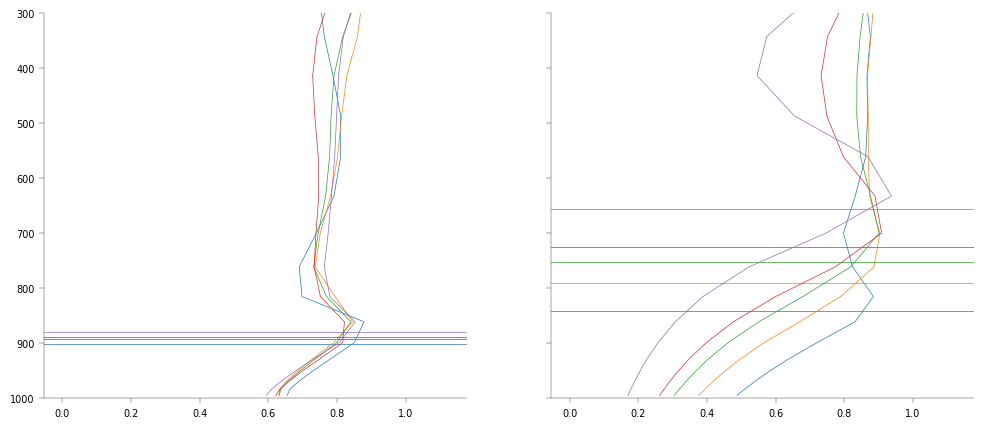

In [399]:
fig, ax = plt.subplots(1, n_exp, figsize=(n_exp*6, 5), sharex=True, sharey=True)
if n_exp == 1:
    ax = [ax]
for i in range(n_exp):
    for j, q in enumerate([1, 25, 50, 75, 99]):
        # ax[i].plot(np.average(subsat_profile_quant3[i, :, :, q-1], axis=1, weights=lat_weights), ds_profile[0].pfull, color=default_colors[j])
        ax[i].plot(np.average(r_profile_quant3[i, :, :, q-1], axis=1, weights=lat_weights), ds_profile[0].pfull, color=default_colors[j])
        ax[i].axhline(np.average(pressure_lcl_quant3[i, :, q-1], axis=0, weights=lat_weights)/100, color=default_colors[j])
ax[0].invert_yaxis()
ax[0].set_ylim(1000, 300)
# ax.set_xlim(-35, 0)

### Link between $\epsilon$ and $Subsat$
Below I plot $\epsilon = h_s - h_{FT}^*$ vs $-Subsat = L_v(q^* - q)$. When we adjust for the fact that the LCL moves further from the surface as $x$ increases, then $Subsat$ stays approx constant over land. So the variation of $Subsat$ at 850hPa with $x$ can be linked to the variation of $p_{LCL}$ with $x$.

In [400]:
subsat_lcl_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
for i in range(n_exp):
    for j in range(n_lat):
        for q in range(n_quant_all):
            subsat_lcl_quant3[i, j, q] = subsat_profile_quant3[i, np.argmin(np.abs(ds_profile[0].pfull.to_numpy() -
                                                                                   (pressure_lcl_quant3[i, j, q]/100))), j, q]

(0.0, 100.0)

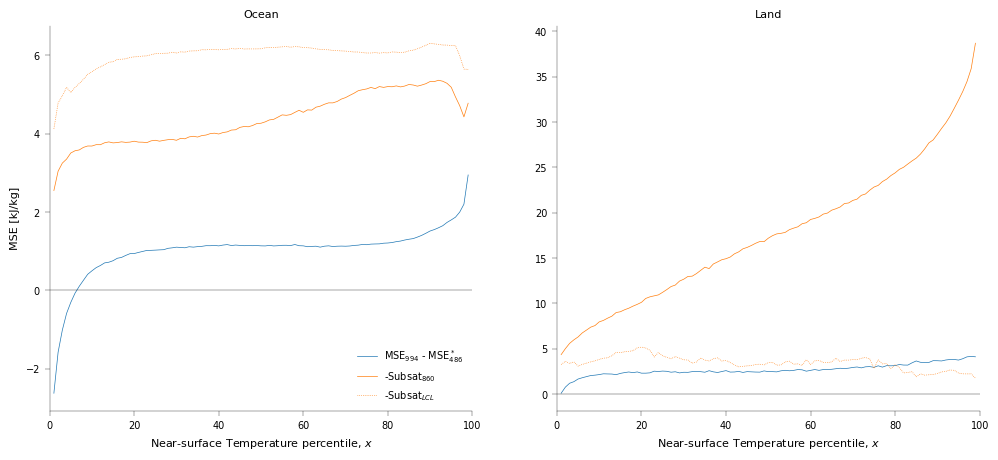

In [401]:
fig, ax = plt.subplots(1, n_exp, figsize=(n_exp*6, 5), sharex=True, sharey=False)
if n_exp == 1:
    ax = [ax]
for i in range(n_exp):
    ax[i].plot(quantiles_all, np.average(epsilon_quant3[i], axis=0, weights=lat_weights), 
               label=f"MSE$_{'{'+str(int(p_surf/100))+'}'}$ - MSE$^*_{'{'+str(int(p_ft/100))+'}'}$")
    ax[i].plot(quantiles_all, np.average(subsat_quant3[i], axis=0, weights=lat_weights), label=f"-Subsat$_{'{'+str(int(p_dry/100))+'}'}$")
    ax[i].plot(quantiles_all, np.average(subsat_lcl_quant3[i], axis=0, weights=lat_weights), label="-Subsat$_{LCL}$", color=default_colors[1], linestyle=':')
    ax[i].set_title(exp_labels[i])
    ax[i].set_xlabel('Near-surface Temperature percentile, $x$')
    ax[i].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_ylabel('MSE [kJ/kg]')
ax[0].legend()
ax[0].set_xlim(0, 100)
# ax2=ax[0].twinx()
# ax2.plot(quantiles_all, np.average(pressure_lcl_quant3[0], axis=0, weights=lat_weights), color='g')

(0.0, 100.0)

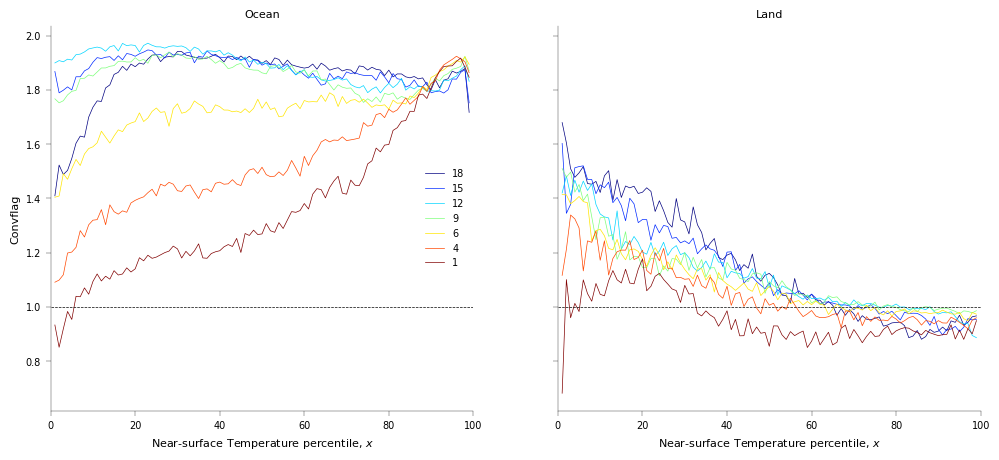

In [402]:
color_seq_lat = plt.cm.jet(np.linspace(0,1,int(n_lat/2)))
fig, ax = plt.subplots(1, n_exp, figsize=(n_exp*6, 5), sharex=True, sharey=True)
if n_exp == 1:
    ax = [ax]
for i in range(n_exp):
    for k in range(int(n_lat/2)):
        ax[i].plot(quantiles_all, convflag_quant3[i, k], color=color_seq_lat[k], label=int(np.abs(ds[0].lat[k])))
        # ax[i].plot(quantiles_all, epsilon_quant3[i, k], color=color_seq_lat[k])
        # ax[i].plot(quantiles_all, subsat_quant3[i, k], color=color_seq_lat[k], linestyle=':')
    # ax[i].plot(quantiles_all, np.average(subsat_lcl_quant3[i], axis=0, weights=lat_weights), label="-Subsat$_{LCL}$", color=default_colors[1], linestyle=':')
    ax[i].set_title(exp_labels[i])
    ax[i].set_xlabel('Near-surface Temperature percentile, $x$')
    ax[i].axhline(1, color='k', linestyle='--')
ax[0].legend(title='Lat [deg]')
ax[0].set_ylabel('Convflag')
ax[0].legend()
ax[0].set_xlim(0, 100)

(0.0, 100.0)

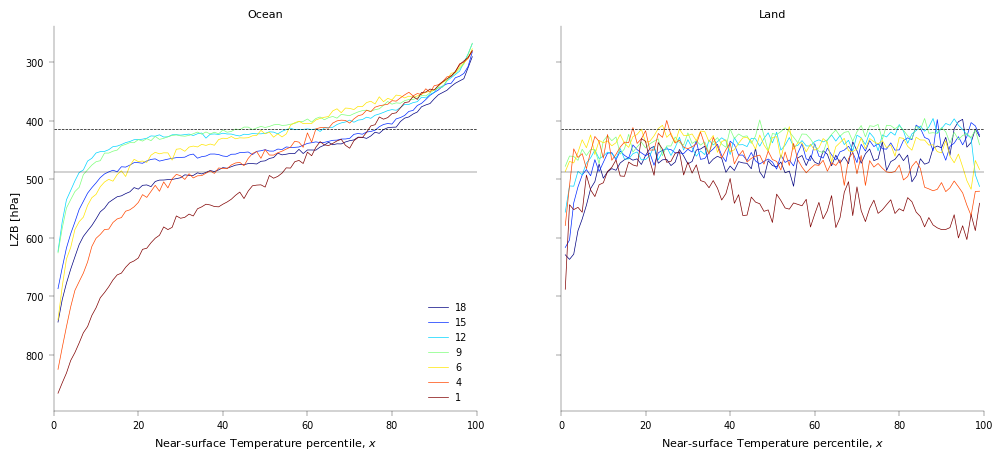

In [403]:
color_seq_lat = plt.cm.jet(np.linspace(0,1,int(n_lat/2)))
fig, ax = plt.subplots(1, n_exp, figsize=(n_exp*6, 5), sharex=True, sharey=True)
if n_exp == 1:
    ax = [ax]
for i in range(n_exp):
    for k in range(int(n_lat/2)):
        ax[i].plot(quantiles_all, lzb(klzbs_quant3[i, k]), color=color_seq_lat[k], label=int(np.abs(ds[0].lat[k])))
        # ax[i].plot(quantiles_all, epsilon_quant3[i, k], color=color_seq_lat[k])
        # ax[i].plot(quantiles_all, subsat_quant3[i, k], color=color_seq_lat[k], linestyle=':')
    # ax[i].plot(quantiles_all, np.average(subsat_lcl_quant3[i], axis=0, weights=lat_weights), label="-Subsat$_{LCL}$", color=default_colors[1], linestyle=':')
    ax[i].set_title(exp_labels[i])
    ax[i].set_xlabel('Near-surface Temperature percentile, $x$')
    ax[i].axhline(p_ft/100, color='k', lw=ax_linewidth)
    ax[i].axhline(lzb(lzb_thresh), color='k', linestyle='--')
ax[0].invert_yaxis()
ax[0].legend(title='Lat [deg]')
ax[0].set_ylabel('LZB [hPa]')
ax[0].legend()
ax[0].set_xlim(0, 100)

(0.0, 100.0)

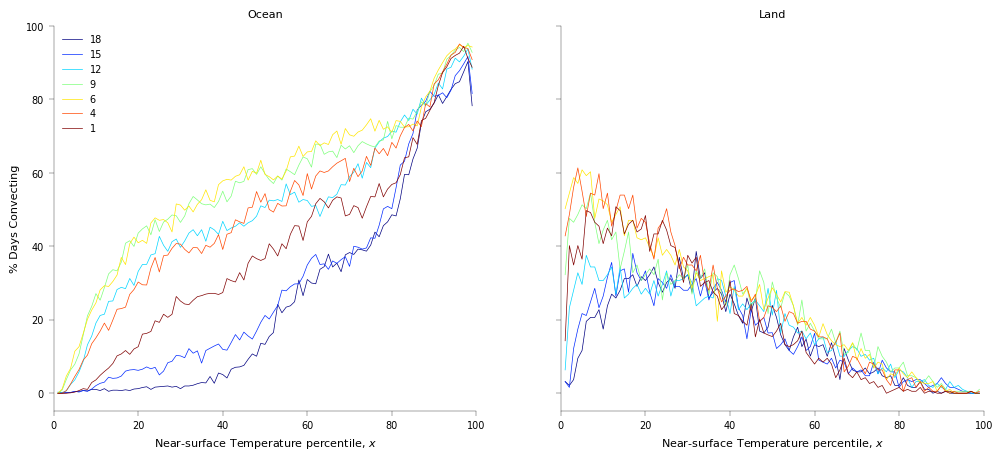

In [404]:
color_seq_lat = plt.cm.jet(np.linspace(0,1,int(n_lat/2)))
fig, ax = plt.subplots(1, n_exp, figsize=(n_exp*6, 5), sharex=True, sharey=True)
if n_exp == 1:
    ax = [ax]
for i in range(n_exp):
    for k in range(int(n_lat/2)):
        ax[i].plot(quantiles_all, fract_convecting_quant3[i, k]*100, color=color_seq_lat[k], label=int(np.abs(ds[0].lat[k])))
        # ax[i].plot(quantiles_all, epsilon_quant3[i, k], color=color_seq_lat[k])
        # ax[i].plot(quantiles_all, subsat_quant3[i, k], color=color_seq_lat[k], linestyle=':')
    # ax[i].plot(quantiles_all, np.average(subsat_lcl_quant3[i], axis=0, weights=lat_weights), label="-Subsat$_{LCL}$", color=default_colors[1], linestyle=':')
    ax[i].set_title(exp_labels[i])
    ax[i].set_xlabel('Near-surface Temperature percentile, $x$')
ax[0].legend(title='Lat [deg]')
ax[0].set_ylabel('% Days Convecting')
ax[0].legend()
ax[0].set_xlim(0, 100)

(0.0, 100.0)

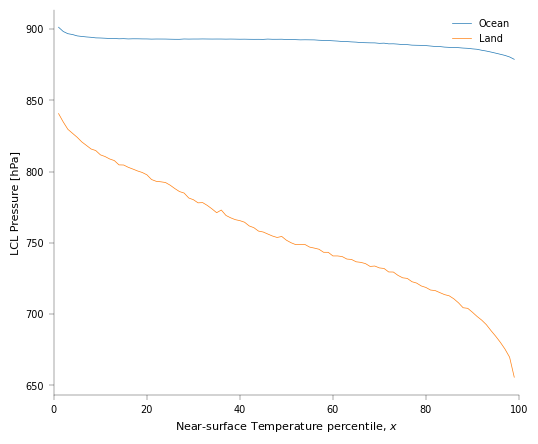

In [405]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5), sharex=True, sharey=True)
for i in range(n_exp):
    ax.plot(quantiles_all, np.average(pressure_lcl_quant3[i], axis=0, weights=lat_weights)/100, color=default_colors[i], label=exp_labels[i])
ax.set_xlabel('Near-surface Temperature percentile, $x$')
ax.set_ylabel('LCL Pressure [hPa]')
ax.legend()
ax.set_xlim(0, 100)